<a href="https://colab.research.google.com/github/KW-ML/ML_Project/blob/main/code/LightGBM_SMOGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,294 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import sys

# 커널을 구성하다보면 에러는 아니지만, 빨간색 네모 박스 warning이 뜨는 경우를 제거 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_low = pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/train_low.csv", encoding = 'utf-8-sig')
test_low =pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/test_low.csv", encoding = 'utf-8-sig')
train_high= pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/train_high.csv", encoding = 'utf-8-sig')
test_high= pd.read_csv("/content/drive/MyDrive/기계학습팀플/코드/data/test_high.csv", encoding = 'utf-8-sig')

In [ ]:
dfTrain = pd.concat([train_low,train_high])
dfTest = pd.concat([test_low,test_high])

In [ ]:
dfSmogn = pd.read_csv('/content/drive/MyDrive/기계학습팀플/코드/data/smogn.csv',encoding='cp949',)

In [ ]:
dfSmogn

,시설용량,생물학적,고도,유입하수량,생물학적 유입하수량,고도 유입하수량,방류량,생물학적 방류량,고도 방류량,유입 COD,...,수계_0,수계_1,수계_2,준공일_day,가동개시일_day,방류수소독방법_염소,방류수소독방법_자외선,방류수소독방법_오존,방류수소독방법_기타,처리효율
0,46,46,0,27.500000,27.500000,0.000000,27.500000,27.500000,0.000000,20.400000,...,1,0,0,8073,8073,1,1,1,1,87.400000
1,35,35,0,21.500000,21.500000,0.000000,21.500000,21.500000,0.000000,41.600000,...,1,0,0,8053,8053,1,1,1,1,90.000000
2,40,0,40,35.900000,0.000000,35.900000,36.700000,0.000000,36.700000,72.400000,...,1,0,0,5482,5482,1,1,1,1,89.200000
3,36,0,36,30.100000,0.000000,30.100000,28.400000,0.000000,28.400000,74.000000,...,1,0,1,5946,5946,1,1,1,1,87.900000
4,45,0,45,15.600000,0.000000,15.600000,15.600000,0.000000,15.600000,41.800000,...,0,1,0,5481,5481,1,1,1,1,83.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197,30,0,30,27.948904,0.000000,27.948904,27.948904,0.000000,27.948904,90.305735,...,0,0,0,8562,8562,1,1,1,1,95.782359
5198,274,0,274,195.250777,0.000000,195.250777,194.929308,0.000000,194.929308,127.651905,...,0,1,0,622,569,1,1,1,1,98.399593
5199,87,0,87,41.784180,0.000000,41.784180,41.784180,0.000000,41.784180,108.227847,...,0,1,0,5866,5866,1,1,1,1,92.625699
5200,44,0,44,43.911212,0.000000,43.911212,43.869036,0.000000,43.869036,18.313310,...,0,0,0,3382,3380,1,1,1,1,86.452759


# **LightGBM**

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn import metrics

In [ ]:
XSmogn = dfSmogn.drop(['처리효율'],axis = 1)
XdfTrain = dfTrain.drop(['처리효율'],axis = 1)
XdfTest = dfTest.drop(['처리효율'],axis = 1)

In [ ]:
YSmogn = dfSmogn['처리효율']
YdfTrain = dfTrain['처리효율']
YdfTest = dfTest['처리효율']

In [ ]:
dfSmote

,시설용량,생물학적,고도,유입하수량,생물학적 유입하수량,고도 유입하수량,방류량,생물학적 방류량,고도 방류량,유입 COD,...,수계_0,수계_1,수계_2,준공일_day,가동개시일_day,방류수소독방법_염소,방류수소독방법_자외선,방류수소독방법_오존,방류수소독방법_기타,처리효율
0,46,46,0,27.5,27.5,0.0,27.5,27.5,0.0,20.4,...,1,0,0,8073,8073,1,1,1,1,87.4
1,35,35,0,21.5,21.5,0.0,21.5,21.5,0.0,41.6,...,1,0,0,8053,8053,1,1,1,1,90.0
2,40,0,40,35.9,0.0,35.9,36.7,0.0,36.7,72.4,...,1,0,0,5482,5482,1,1,1,1,89.2
3,36,0,36,30.1,0.0,30.1,28.4,0.0,28.4,74.0,...,1,0,1,5946,5946,1,1,1,1,87.9
4,45,0,45,15.6,0.0,15.6,15.6,0.0,15.6,41.8,...,0,1,0,5481,5481,1,1,1,1,83.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,30,0,30,20.5,0.0,0.0,20.5,0.0,0.0,13.7,...,0,1,0,3247,3247,1,1,1,1,68.1
6590,15,0,15,14.0,0.0,0.0,14.0,0.0,0.0,50.7,...,1,0,1,640,365,1,1,1,1,89.7
6591,20,20,0,7.4,7.4,0.0,7.4,7.4,0.0,19.9,...,1,0,0,6590,6590,1,1,1,1,86.7
6592,15,0,15,7.1,0.0,7.1,7.1,0.0,7.1,27.1,...,1,0,1,4566,4462,1,1,1,1,84.2


In [ ]:
dfTrain

,시설용량,생물학적,고도,유입하수량,생물학적 유입하수량,고도 유입하수량,방류량,생물학적 방류량,고도 방류량,유입 COD,...,수계_0,수계_1,수계_2,준공일_day,가동개시일_day,방류수소독방법_염소,방류수소독방법_자외선,방류수소독방법_오존,방류수소독방법_기타,처리효율
0,46,46,0,27.5,27.5,0.0,27.5,27.5,0.0,20.4,...,1,0,0,8073,8073,1,1,1,1,87.4
1,35,35,0,21.5,21.5,0.0,21.5,21.5,0.0,41.6,...,1,0,0,8053,8053,1,1,1,1,90.0
2,40,0,40,35.9,0.0,35.9,36.7,0.0,36.7,72.4,...,1,0,0,5482,5482,1,1,1,1,89.2
3,36,0,36,30.1,0.0,30.1,28.4,0.0,28.4,74.0,...,1,0,1,5946,5946,1,1,1,1,87.9
4,45,0,45,15.6,0.0,15.6,15.6,0.0,15.6,41.8,...,0,1,0,5481,5481,1,1,1,1,83.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,490,0,490,490.0,0.0,490.0,490.0,0.0,490.0,91.9,...,0,1,0,4262,4262,1,1,1,1,98.7
3293,1700,0,1700,1156.7,0.0,1156.7,1041.6,0.0,1041.6,78.5,...,0,0,1,1844,1309,1,1,1,1,97.5
3294,20,0,20,18.7,0.0,18.7,18.7,0.0,18.7,58.7,...,0,1,0,6599,6599,1,1,1,1,98.1
3295,5250,0,5250,4601.9,0.0,4601.9,4001.6,0.0,4001.6,51.4,...,0,1,0,7357,7370,0,1,0,0,99.1


In [ ]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 20,
    'learnnig_rage': 0.01,
    'metric': {'l2','l1'},
    'verbose': -1
}

In [ ]:
# loading data
lgb_train = lgb.Dataset(XdfTrain, YdfTrain)
lgb_eval = lgb.Dataset(XdfTest, YdfTest, reference=lgb_train)

In [ ]:
# fitting the model
model = lgb.train(params, valid_sets=lgb_eval,
                 early_stopping_rounds=30,
                 train_set=lgb_train)

[1]	valid_0's l2: 16.0803	valid_0's l1: 2.17388
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 14.7767	valid_0's l1: 2.03852
[3]	valid_0's l2: 13.7272	valid_0's l1: 1.91855
[4]	valid_0's l2: 12.8493	valid_0's l1: 1.81527
[5]	valid_0's l2: 12.0889	valid_0's l1: 1.7275
[6]	valid_0's l2: 11.3448	valid_0's l1: 1.63666
[7]	valid_0's l2: 10.8081	valid_0's l1: 1.57219
[8]	valid_0's l2: 10.3119	valid_0's l1: 1.50498
[9]	valid_0's l2: 9.92152	valid_0's l1: 1.4454
[10]	valid_0's l2: 9.5626	valid_0's l1: 1.40269
[11]	valid_0's l2: 9.21691	valid_0's l1: 1.35614
[12]	valid_0's l2: 8.92642	valid_0's l1: 1.31758
[13]	valid_0's l2: 8.64499	valid_0's l1: 1.28185
[14]	valid_0's l2: 8.42813	valid_0's l1: 1.24936
[15]	valid_0's l2: 8.20408	valid_0's l1: 1.21827
[16]	valid_0's l2: 8.11855	valid_0's l1: 1.19754
[17]	valid_0's l2: 7.96054	valid_0's l1: 1.17144
[18]	valid_0's l2: 7.79045	valid_0's l1: 1.14669
[19]	valid_0's l2: 7.65791	valid_0's l1: 1.1258
[20]	valid_0's l2: 7

In [ ]:
# prediction
Y_pred = model.predict(XdfTest)

# accuracy check
mse = mean_squared_error(YdfTest, Y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MSE: 6.02
RMSE: 2.45


In [ ]:
from sklearn.metrics import r2_score
r2_score(YdfTest, Y_pred)

0.6576445854463282

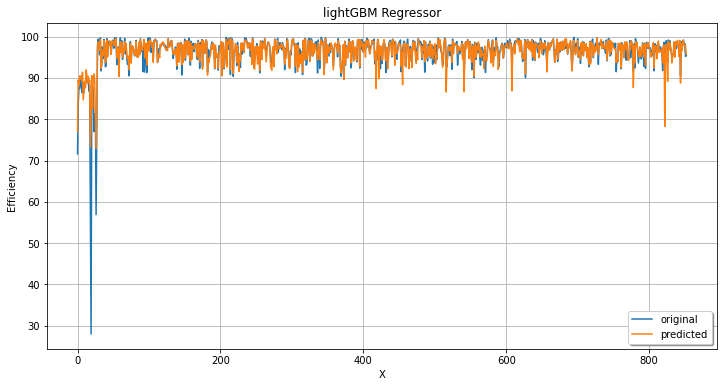

In [ ]:
# visualizing in a plot
x_ax = range(len(YdfTest))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, YdfTest, label="original")
plt.plot(x_ax, Y_pred, label="predicted")
plt.title("lightGBM Regressor")
plt.xlabel('X')
plt.ylabel('Efficiency')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

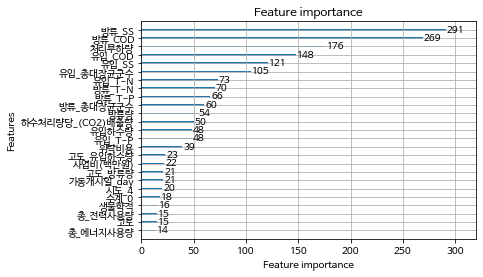

In [ ]:
# plotting feature importance
#lgb.plot_importance(model,max_num_features=25)

In [ ]:
# laoding data
lgb_train = lgb.Dataset(XSmogn, YSmogn)
lgb_eval = lgb.Dataset(XdfTest, YdfTest, reference=lgb_train)

In [ ]:
# fitting the model
model = lgb.train(params, valid_sets=lgb_eval,
                 early_stopping_rounds=30,
                 train_set=lgb_train)

[1]	valid_0's l2: 16.3643	valid_0's l1: 2.36052
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 15.0141	valid_0's l1: 2.20595
[3]	valid_0's l2: 13.9577	valid_0's l1: 2.07199
[4]	valid_0's l2: 12.9933	valid_0's l1: 1.94007
[5]	valid_0's l2: 12.1929	valid_0's l1: 1.82582
[6]	valid_0's l2: 11.4635	valid_0's l1: 1.73304
[7]	valid_0's l2: 10.9437	valid_0's l1: 1.6506
[8]	valid_0's l2: 10.4749	valid_0's l1: 1.57828
[9]	valid_0's l2: 10.2201	valid_0's l1: 1.5334
[10]	valid_0's l2: 9.92138	valid_0's l1: 1.48862
[11]	valid_0's l2: 9.68599	valid_0's l1: 1.4592
[12]	valid_0's l2: 9.43271	valid_0's l1: 1.43033
[13]	valid_0's l2: 9.25723	valid_0's l1: 1.41709
[14]	valid_0's l2: 9.14995	valid_0's l1: 1.40143
[15]	valid_0's l2: 9.03664	valid_0's l1: 1.38789
[16]	valid_0's l2: 8.92306	valid_0's l1: 1.39103
[17]	valid_0's l2: 8.90123	valid_0's l1: 1.39811
[18]	valid_0's l2: 8.86632	valid_0's l1: 1.39723
[19]	valid_0's l2: 8.87269	valid_0's l1: 1.40006
[20]	valid_0's l2: 

In [ ]:
# prediction
Y_pred = model.predict(XdfTest)

# accuracy check
mse = mean_squared_error(YdfTest, Y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MSE: 8.61
RMSE: 2.93


In [ ]:
from sklearn.metrics import r2_score
r2_score(YdfTest, Y_pred)

0.5106105060208181

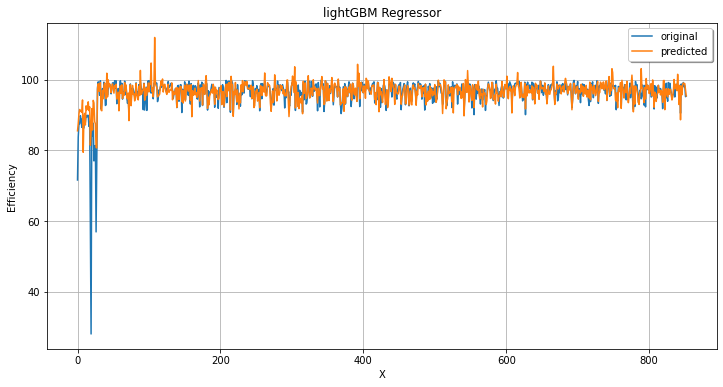

In [ ]:
# visualizing in a plot
x_ax = range(len(YdfTest))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, YdfTest, label="original")
plt.plot(x_ax, Y_pred, label="predicted")
plt.title("lightGBM Regressor")
plt.xlabel('X')
plt.ylabel('Efficiency')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  